<img src="../images/logos/wradlib_logo.svg.png" width=250 alt="wradlib logo png" align="left"></img>

# wradlib data quality

---

## Overview

Within this notebook, we will cover:

1. Reading radar volume data into xarray based RadarVolume
1. Wrapping numpy-based functions to work with Xarray
1. Clutter detection
1. Beam Blockage calculation

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Xarray Basics](https://tutorial.xarray.dev/intro.html) | Helpful | Basic Dataset/DataArray |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | Basic Plotting |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Projections |

- **Time to learn**: 10 minutes

---

## Imports

In [1]:
import glob
import os

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import wradlib as wrl

## Import Swiss Radar Data from CfRadial1 Volumes

We use some of the pyrad example data here. Sweeps are provided as single files, so we open each file separately and create the RadarVolume from the open Datasets.

In [2]:
fglob = "./data/example_pyrad/22179/MLL22179/MLL2217907250U*.nc"
flist = glob.glob(fglob)
flist.sort()
print("Files available: {}".format(len(flist)))

Files available: 20


In [3]:
ds = [xr.open_dataset(f, group="sweep_0", engine="cfradial1", chunks={}) for f in flist]

In [4]:
vol = wrl.io.RadarVolume(engine="cfradial1")
vol.extend(ds)


In [6]:
display(vol)

<wradlib.RadarVolume>
Dimension(s): (sweep: 20)
Elevation(s): (-0.2, 0.4, 1.0, 1.6, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 11.0, 13.0, 16.0, 20.0, 25.0, 30.0, 35.0, 40.0)

In [8]:
sweep_number = 3
display(vol[sweep_number])

<xarray.Dataset>
Dimensions:                              (azimuth: 360, range: 324)
Coordinates:
    time                                 (azimuth) datetime64[ns] dask.array<chunksize=(360,), meta=np.ndarray>
  * range                                (range) float32 250.0 ... 1.617e+05
  * azimuth                              (azimuth) float32 0.5274 1.53 ... 359.5
    elevation                            (azimuth) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    latitude                             float32 ...
    longitude                            float32 ...
    altitude                             float32 ...
Data variables: (12/14)
    reflectivity                         (azimuth, range) float32 dask.array<chunksize=(360, 324), meta=np.ndarray>
    signal_to_noise_ratio                (azimuth, range) float32 dask.array<chunksize=(360, 324), meta=np.ndarray>
    reflectivity_vv                      (azimuth, range) float32 dask.array<chunksize=(360, 324), meta=np.ndarray>
    differential_reflectivity            (azimuth, range) float32 dask.array<chunksize=(360, 324), meta=np.ndarray>
    uncorrected_cross_correlation_ratio  (azimuth, range) float32 dask.array<chunksize=(360, 324), meta=np.ndarray>
    uncorrected_differential_phase       (azimuth, range) float32 dask.array<chunksize=(360, 324), meta=np.ndarray>
    ...                                   ...
    reflectivity_hh_clut                 (azimuth, range) float32 dask.array<chunksize=(360, 324), meta=np.ndarray>
    sweep_number                         int64 ...
    sweep_fixed_angle                    float32 ...
    sweep_mode                           |S32 ...
    pulse_width                          (azimuth) timedelta64[ns] dask.array<chunksize=(360,), meta=np.ndarray>
    nyquist_velocity                     (azimuth) float32 dask.array<chunksize=(360,), meta=np.ndarray>

## Clutter detection with Gabella

While in Switzerland, why not use the well-known clutter detection scheme by Marco Gabella et. al.

### Wrap Gabella Clutter detection in Xarray `apply_ufunc`

The routine is implemented in wradlib in pure `Numpy`. `Numpy` based processing routines can be transformed to a first class `Xarray` citizen with the help of `xr.apply_ufunc`.

In [9]:
def extract_clutter(da, wsize=5, thrsnorain=0, tr1=6.0, n_p=6, tr2=1.3, rm_nans=False):
    return xr.apply_ufunc(
        wrl.clutter.filter_gabella,
        da,
        input_core_dims=[["azimuth", "range"]],
        output_core_dims=[["azimuth", "range"]],
        dask="parallelized",
        kwargs=dict(
            wsize=wsize,
            thrsnorain=thrsnorain,
            tr1=tr1,
            n_p=n_p,
            tr2=tr2,
            rm_nans=rm_nans,
        ),
    )

### Calculate clutter map

Now we apply Gabella scheme and add the result to the Dataset.

In [10]:
swp = vol[sweep_number]
clmap = swp.reflectivity_hh_clut.pipe(
    extract_clutter, wsize=5, thrsnorain=0.0, tr1=21.0, n_p=23, tr2=1.3, rm_nans=False
)
swp = swp.assign({"CMAP": clmap})
display(swp)

<xarray.Dataset>
Dimensions:                              (azimuth: 360, range: 324)
Coordinates:
    time                                 (azimuth) datetime64[ns] dask.array<chunksize=(360,), meta=np.ndarray>
  * range                                (range) float32 250.0 ... 1.617e+05
  * azimuth                              (azimuth) float32 0.5274 1.53 ... 359.5
    elevation                            (azimuth) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    latitude                             float32 ...
    longitude                            float32 ...
    altitude                             float32 ...
Data variables: (12/15)
    reflectivity                         (azimuth, range) float32 dask.array<chunksize=(360, 324), meta=np.ndarray>
    signal_to_noise_ratio                (azimuth, range) float32 dask.array<chunksize=(360, 324), meta=np.ndarray>
    reflectivity_vv                      (azimuth, range) float32 dask.array<chunksize=(360, 324), meta=np.ndarray>
    differential_reflectivity            (azimuth, range) float32 dask.array<chunksize=(360, 324), meta=np.ndarray>
    uncorrected_cross_correlation_ratio  (azimuth, range) float32 dask.array<chunksize=(360, 324), meta=np.ndarray>
    uncorrected_differential_phase       (azimuth, range) float32 dask.array<chunksize=(360, 324), meta=np.ndarray>
    ...                                   ...
    sweep_number                         int64 ...
    sweep_fixed_angle                    float32 ...
    sweep_mode                           |S32 ...
    pulse_width                          (azimuth) timedelta64[ns] dask.array<chunksize=(360,), meta=np.ndarray>
    nyquist_velocity                     (azimuth) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    CMAP                                 (azimuth, range) bool dask.array<chunksize=(360, 324), meta=np.ndarray>

### Plot Reflectivities, Clutter and Cluttermap

In [11]:
from osgeo import osr

wgs84 = osr.SpatialReference()
wgs84.ImportFromEPSG(4326)

0

Text(0.5, 1.0, 'Reflectivity clutter removed')

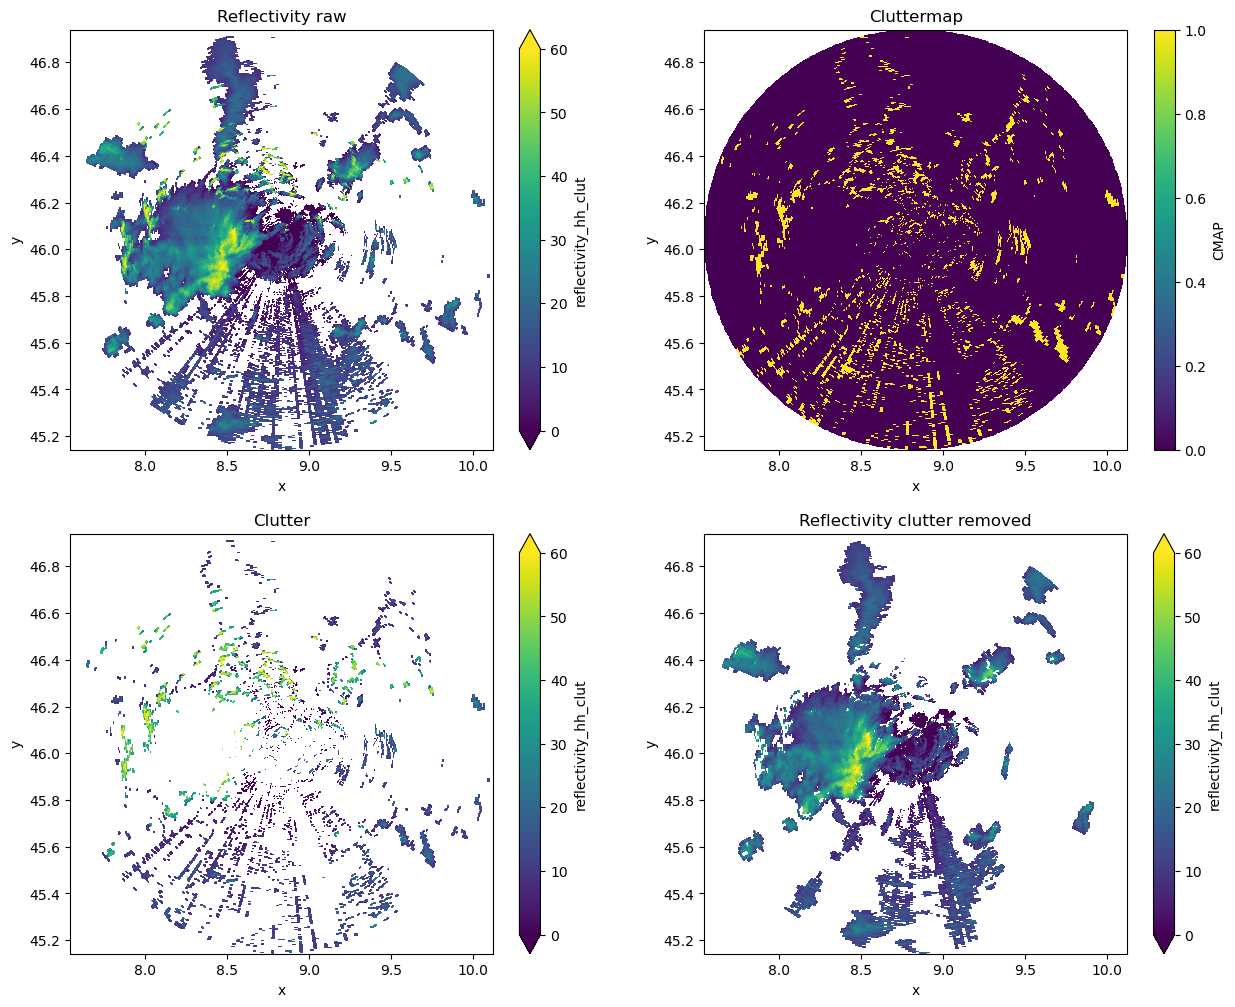

In [12]:
fig = plt.figure(figsize=(15, 12))

swpx = swp.sel(range=slice(0, 100000)).pipe(wrl.georef.georeference_dataset, proj=wgs84)

ax1 = fig.add_subplot(221)
swpx.reflectivity_hh_clut.plot(x="x", y="y", ax=ax1, vmin=0, vmax=60)
ax1.set_title("Reflectivity raw")

ax2 = fig.add_subplot(222)
swpx.CMAP.plot(x="x", y="y", ax=ax2)
ax2.set_title("Cluttermap")

ax3 = fig.add_subplot(223)
swpx.reflectivity_hh_clut.where(swpx.CMAP == 1).plot(
    x="x", y="y", ax=ax3, vmin=0, vmax=60
)
ax3.set_title("Clutter")

ax4 = fig.add_subplot(224)
swpx.reflectivity_hh_clut.where(swpx.CMAP < 1).plot(
    x="x", y="y", ax=ax4, vmin=0, vmax=60
)
ax4.set_title("Reflectivity clutter removed")

## SRTM based clutter and beamblockage processing

### Download needed SRTM data

For the course we already provide the needed SRTM tiles. For normal operation you would need a NASA EARTHDATA account and a connected bearer token.

The data will be loaded using GDAL machinery and transformed into an Xarray DataArray.

In [13]:
extent = wrl.zonalstats.get_bbox(swpx.x.values, swpx.y.values)
extent

{'left': 7.545772342625747,
 'right': 10.120652596829073,
 'bottom': 45.14416090772705,
 'top': 46.9372157592286}

In [14]:
# apply fake token, data is already available
os.environ["WRADLIB_EARTHDATA_BEARER_TOKEN"] = ""
# set location of wradlib-data, where wradlib will search for any available data
os.environ["WRADLIB_DATA"] = "data/wradlib-data"
# get the tiles
dem = wrl.io.get_srtm(extent.values())

In [15]:
elevation = wrl.georef.read_gdal_values(dem)
coords = wrl.georef.read_gdal_coordinates(dem)

In [16]:
elev = xr.DataArray(
    data=elevation,
    dims=["y", "x"],
    coords={"lat": (["y", "x"], coords[..., 1]), "lon": (["y", "x"], coords[..., 0])},
)
elev

<xarray.DataArray (y: 2401, x: 4801)>
array([[ 422,  422,  422, ..., 1846, 1798, 1745],
       [ 422,  422,  422, ..., 1856, 1807, 1748],
       [ 422,  422,  422, ..., 1815, 1781, 1740],
       ...,
       [2403, 2379, 2357, ...,   14,   15,   15],
       [2408, 2387, 2365, ...,   14,   15,   14],
       [2428, 2411, 2397, ...,   13,   13,   13]], dtype=int16)
Coordinates:
    lat      (y, x) float64 47.0 47.0 47.0 47.0 47.0 ... 45.0 45.0 45.0 45.0
    lon      (y, x) float64 7.0 7.001 7.002 7.003 7.003 ... 11.0 11.0 11.0 11.0
Dimensions without coordinates: y, x

### Plot Clutter on DEM

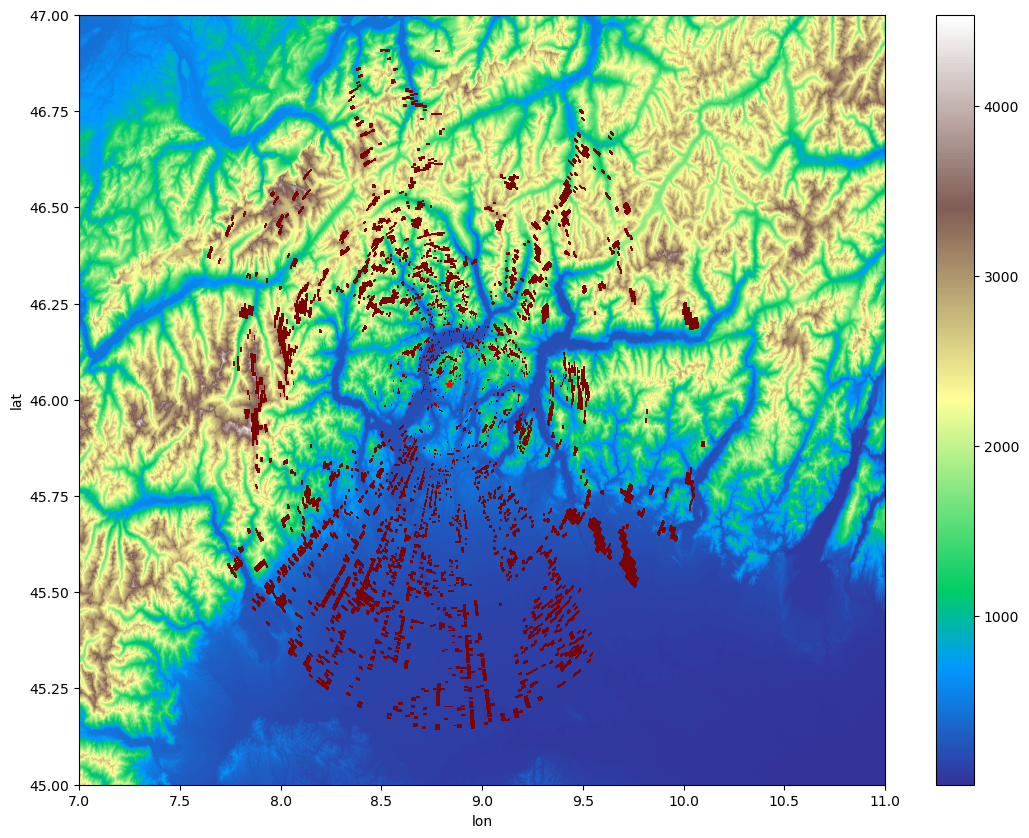

In [17]:
fig = plt.figure(figsize=(13, 10))
ax1 = fig.add_subplot(111)

swpx.CMAP.where(swpx.CMAP == 1).plot(
    x="x", y="y", ax=ax1, vmin=0, vmax=1, cmap="turbo", add_colorbar=False
)
ax1.set_title("Reflectivity corr")

ax1.plot(swpx.longitude.values, swpx.latitude.values, marker="*", c="r")

elev.plot(x="lon", y="lat", ax=ax1, zorder=-2, cmap="terrain")

### Use hvplot for interactive zooming and panning

Often it is desirable to quickly zoom and pan in the plots. Although matplotlib has that ability, it still is quite slow. Here `hvplot`, a `holoviews` based plotting framework, can be utilized. As frontend `bokeh` is used.

In [18]:
import hvplot
import hvplot.xarray


We need to rechunk the coordinates as hvplot needs chunked variables and coords.

In [19]:
cl = (
    swpx.CMAP.where(swpx.CMAP == 1)
    .chunk(chunks={})
    .hvplot.quadmesh(
        x="x", y="y", cmap="Reds", width=800, height=700, clim=(0, 1), alpha=0.6
    )
)
dm = elev.hvplot.quadmesh(
    x="lon",
    y="lat",
    cmap="terrain",
    width=800,
    height=700,
    clim=(0, 4000),
    rasterize=True,
)
dm * cl

:DynamicMap   []
   :Overlay
      .Image.I    :Image   [lon,lat]   (value)
      .QuadMesh.I :QuadMesh   [x,y]   (CMAP)

### Convert DEM to spherical coordinates

In [20]:
sitecoords = (swpx.longitude.values, swpx.latitude.values, swpx.altitude.values)
r = swpx.range.values
az = swpx.azimuth.values
bw = 0.8
beamradius = wrl.util.half_power_radius(r, bw)

In [21]:
rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(
    dem, nodata=-32768.0
)

rlimits = (extent["left"], extent["bottom"], extent["right"], extent["top"])
# Clip the region inside our bounding box
ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
rastercoords = rastercoords[ind[1] : ind[3], ind[0] : ind[2], ...]
rastervalues = rastervalues[ind[1] : ind[3], ind[0] : ind[2]]

polcoords = np.dstack([swpx.x.values, swpx.y.values])
# Map rastervalues to polar grid points
polarvalues = wrl.ipol.cart_to_irregular_spline(
    rastercoords, rastervalues, polcoords, order=3, prefilter=False
)

### Partial and Cumulative Beamblockage

In [22]:
PBB = wrl.qual.beam_block_frac(polarvalues, swpx.z.values, beamradius)
PBB = np.ma.masked_invalid(PBB)
print(PBB.shape)

(360, 200)


/home/jgiles/mambaforge/envs/wradlib4/lib/python3.11/site-packages/wradlib/qual.py:127: RuntimeWarning: invalid value encountered in sqrt
  numer = (ya * np.sqrt(a**2 - y**2)) + (a * np.arcsin(ya)) + (np.pi * a / 2.0)
/home/jgiles/mambaforge/envs/wradlib4/lib/python3.11/site-packages/wradlib/qual.py:127: RuntimeWarning: invalid value encountered in arcsin
  numer = (ya * np.sqrt(a**2 - y**2)) + (a * np.arcsin(ya)) + (np.pi * a / 2.0)


In [23]:
CBB = wrl.qual.cum_beam_block_frac(PBB)
print(CBB.shape)

(360, 200)


### Plotting Beamblockage


In [24]:
# just a little helper function to style x and y axes of our maps
def annotate_map(ax, cm=None, title=""):
    xticks = ax.get_xticks()
    ticks = (xticks / 1000).astype(int)
    ax.set_xticks(xticks)
    ax.set_xticklabels(ticks)
    yticks = ax.get_yticks()
    ticks = (yticks / 1000).astype(int)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ticks)
    ax.set_xlabel("Kilometers")
    ax.set_ylabel("Kilometers")
    if not cm is None:
        plt.colorbar(cm, ax=ax)
    if not title == "":
        ax.set_title(title)
    ax.grid()

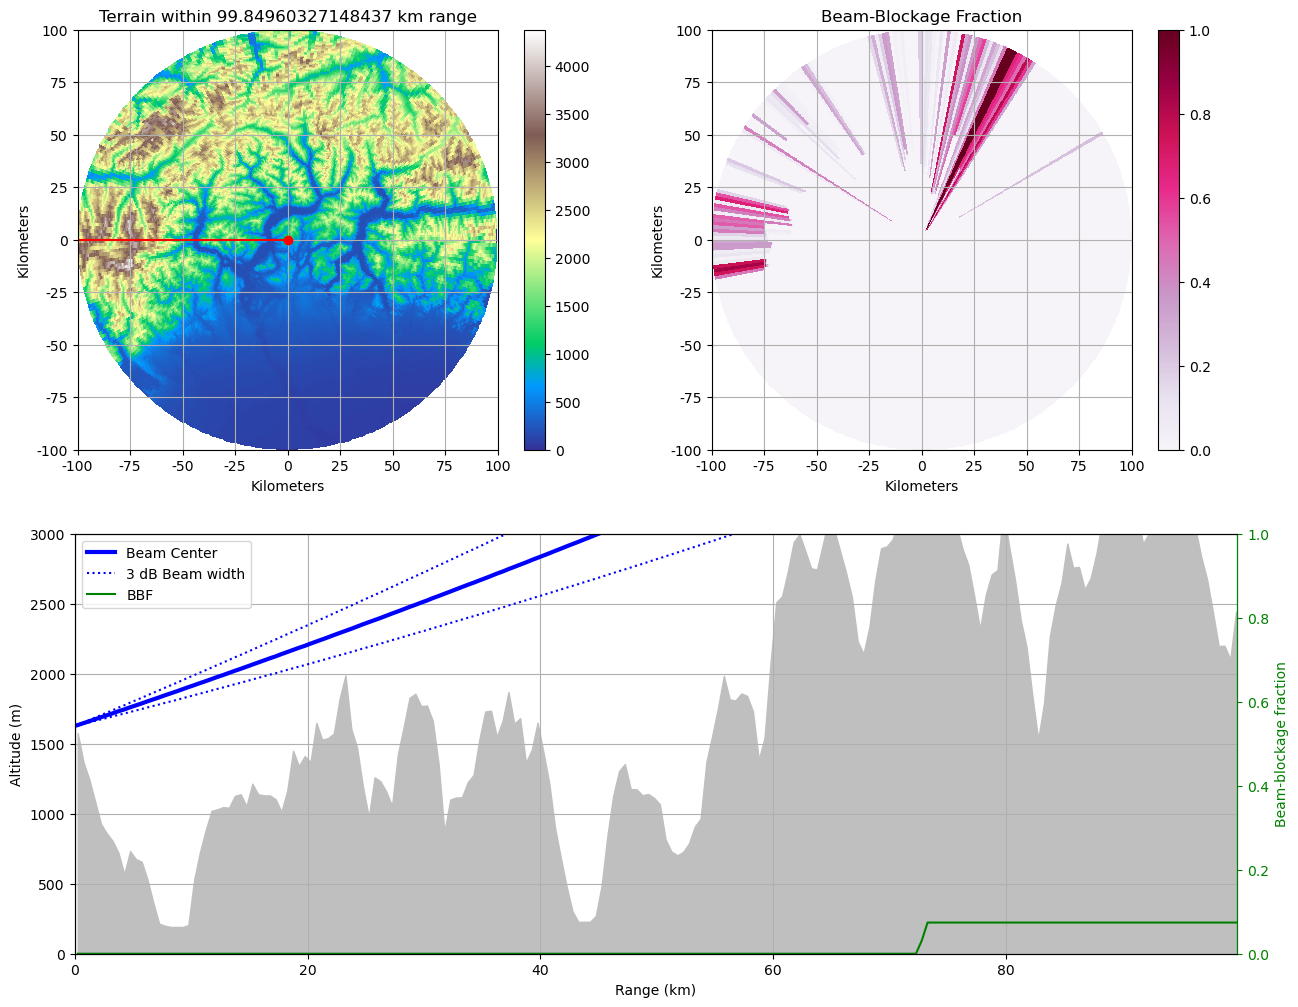

In [25]:
alt = swpx.z.values
fig = plt.figure(figsize=(15, 12))

# create subplots
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

# azimuth angle
angle = 270

# Plot terrain (on ax1)
ax1, dem = wrl.vis.plot_ppi(
    polarvalues, ax=ax1, r=r, az=az, cmap=mpl.cm.terrain, vmin=0.0
)
ax1.plot(
    [0, np.sin(np.radians(angle)) * 1e5], [0, np.cos(np.radians(angle)) * 1e5], "r-"
)
ax1.plot(sitecoords[0], sitecoords[1], "ro")
annotate_map(ax1, dem, "Terrain within {0} km range".format(np.max(r / 1000.0) + 0.1))
ax1.set_xlim(-100000, 100000)
ax1.set_ylim(-100000, 100000)

# Plot CBB (on ax2)
ax2, cbb = wrl.vis.plot_ppi(CBB, ax=ax2, r=r, az=az, cmap=mpl.cm.PuRd, vmin=0, vmax=1)
annotate_map(ax2, cbb, "Beam-Blockage Fraction")
ax2.set_xlim(-100000, 100000)
ax2.set_ylim(-100000, 100000)

# Plot single ray terrain profile on ax3
(bc,) = ax3.plot(r / 1000.0, alt[angle, :], "-b", linewidth=3, label="Beam Center")
(b3db,) = ax3.plot(
    r / 1000.0,
    (alt[angle, :] + beamradius),
    ":b",
    linewidth=1.5,
    label="3 dB Beam width",
)
ax3.plot(r / 1000.0, (alt[angle, :] - beamradius), ":b")
ax3.fill_between(r / 1000.0, 0.0, polarvalues[angle, :], color="0.75")
ax3.set_xlim(0.0, np.max(r / 1000.0) + 0.1)
ax3.set_ylim(0.0, 3000)
ax3.set_xlabel("Range (km)")
ax3.set_ylabel("Altitude (m)")
ax3.grid()

axb = ax3.twinx()
(bbf,) = axb.plot(r / 1000.0, CBB[angle, :], "-g", label="BBF")
axb.spines["right"].set_color("g")
axb.tick_params(axis="y", colors="g")
axb.set_ylabel("Beam-blockage fraction", c="g")
axb.set_ylim(0.0, 1.0)
axb.set_xlim(0.0, np.max(r / 1000.0) + 0.1)


legend = ax3.legend(
    (bc, b3db, bbf),
    ("Beam Center", "3 dB Beam width", "BBF"),
    loc="upper left",
    fontsize=10,
)

### Plotting Beamblockage on Curvelinear Grid

Here you get an better impression of the actual beam progression .

In [26]:
def height_formatter(x, pos):
    x = (x - 6370000) / 1000
    fmt_str = "{:g}".format(x)
    return fmt_str


def range_formatter(x, pos):
    x = x / 1000.0
    fmt_str = "{:g}".format(x)
    return fmt_str

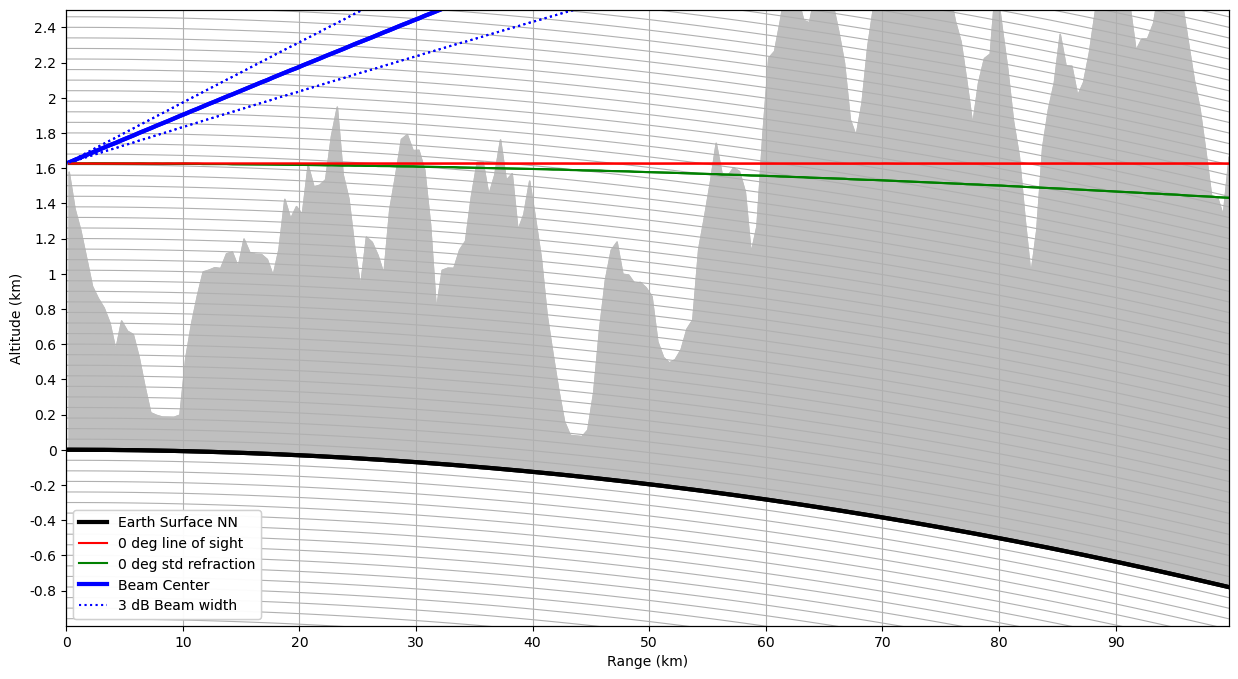

In [27]:
fig = plt.figure(figsize=(15, 8))

cgax, caax, paax = wrl.vis.create_cg(fig=fig, rot=0, scale=1)

# azimuth angle
angle = 270

# fix grid_helper
er = 6370000
gh = cgax.get_grid_helper()
gh.grid_finder.grid_locator2._nbins = 80
gh.grid_finder.grid_locator2._steps = [1, 2, 4, 5, 10]

# calculate beam_height and arc_distance for ke=1
# means line of sight
bhe = wrl.georef.bin_altitude(r, 0, sitecoords[2], re=er, ke=1.0)
ade = wrl.georef.bin_distance(r, 0, sitecoords[2], re=er, ke=1.0)
nn0 = np.zeros_like(r)
# for nice plotting we assume earth_radius = 6370000 m
ecp = nn0 + er
# theta (arc_distance sector angle)
thetap = -np.degrees(ade / er) + 90.0

# zero degree elevation with standard refraction
bh0 = wrl.georef.bin_altitude(r, 0, sitecoords[2], re=er)

# plot (ecp is earth surface normal null)
(bes,) = paax.plot(thetap, ecp, "-k", linewidth=3, label="Earth Surface NN")
(bc,) = paax.plot(thetap, ecp + alt[angle, :], "-b", linewidth=3, label="Beam Center")
(bc0r,) = paax.plot(thetap, ecp + bh0, "-g", label="0 deg Refraction")
(bc0n,) = paax.plot(thetap, ecp + bhe, "-r", label="0 deg line of sight")
(b3db,) = paax.plot(
    thetap, ecp + alt[angle, :] + beamradius, ":b", label="+3 dB Beam width"
)
paax.plot(thetap, ecp + alt[angle, :] - beamradius, ":b", label="-3 dB Beam width")

# orography
paax.fill_between(thetap, ecp, ecp + polarvalues[angle, :], color="0.75")

# shape axes
cgax.set_xlim(0, np.max(ade))
cgax.set_ylim([ecp.min() - 1000, ecp.max() + 2500])
caax.grid(True, axis="x")
cgax.grid(True, axis="y")
cgax.axis["top"].toggle(all=False)
caax.yaxis.set_major_locator(
    mpl.ticker.MaxNLocator(steps=[1, 2, 4, 5, 10], nbins=20, prune="both")
)
caax.xaxis.set_major_locator(mpl.ticker.MaxNLocator())
caax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(height_formatter))
caax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(range_formatter))

caax.set_xlabel("Range (km)")
caax.set_ylabel("Altitude (km)")

legend = paax.legend(
    (bes, bc0n, bc0r, bc, b3db),
    (
        "Earth Surface NN",
        "0 deg line of sight",
        "0 deg std refraction",
        "Beam Center",
        "3 dB Beam width",
    ),
    loc="lower left",
    fontsize=10,
)

## Use Clutter and Beamblockage as Quality Index

Simple masking with cumulative beam blockage and Gabella.

In [28]:
swpx = swpx.assign({"CBB": (["azimuth", "range"], CBB)})
# recalculate georeferencing for AEQD
swpx = swpx.pipe(wrl.georef.georeference_dataset)

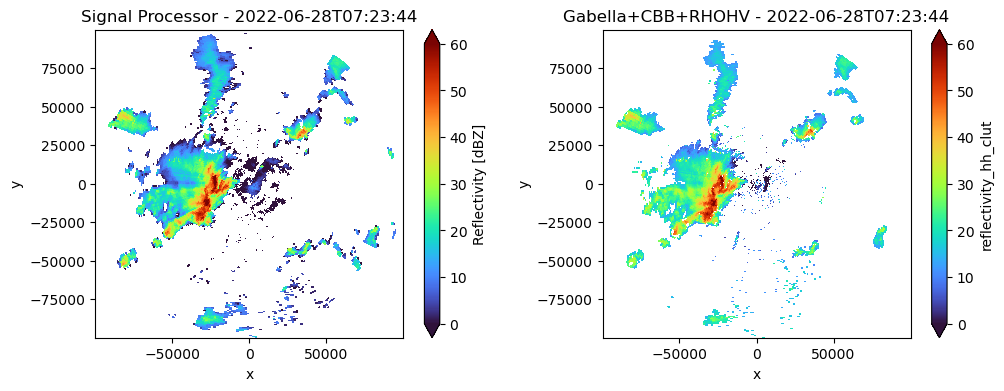

In [31]:
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(121)
swpx.reflectivity.plot(x="x", y="y", ax=ax1, cmap="turbo", vmin=0, vmax=60)
ax1.set_title(f"Signal Processor - {swpx.time.values.astype('M8[s]')[0]}")
ax1.set_aspect("equal")

ax2 = fig.add_subplot(122)
# CBB > 0.5, CMAP == 1, RHOHV < 0.8 is masked
swpx.where(
    (swpx.CBB <= 0.5)
    & (swpx.CMAP < 1.0)
    & (swpx.uncorrected_cross_correlation_ratio >= 0.8)
).reflectivity_hh_clut.plot(x="x", y="y", ax=ax2, cmap="turbo", vmin=0, vmax=60)
ax2.set_title(f"Gabella+CBB+RHOHV - {swpx.time.values.astype('M8[s]')[0]}")
ax2.set_aspect("equal")

---

## Summary
We've just learned how to use $\omega radlib$'s Gabella clutter detection for single sweeps. Wrapping numpy based functions for use with `xarray.apply_ufunc` has been shown. We've looked into digital elevation maps and beam blockage calculations.


## Resources and references

- [SRTM - NASA - EARTHDATA](https://urs.earthdata.nasa.gov/)
- [xarray](https://docs.xarray.dev)
- [apply_ufunc](https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html)
- [dask](https://docs.dask.org/)
- [gdal](https://gdal.org/index.html)
- [hvplot](https://hvplot.holoviz.org/)
- [wradlib xarray backends](https://docs.wradlib.org/en/stable/notebooks/fileio/wradlib_xarray_backends.html)
- [CfRadial1](https://ncar.github.io/CfRadial/)
- [OPERA ODIM_H5](https://www.eumetnet.eu/activities/observations-programme/current-activities/opera/)
- [WMO JET-OWR](https://community.wmo.int/governance/commission-membership/commission-observation-infrastructure-and-information-systems-infcom/commission-infrastructure-officers/infcom-management-group/standing-committee-measurements-instrumentation-and-traceability-sc-mint/joint-expert-team)